# 재건축 여부에 따른 가격 변화

데이터 분석 결과, 30년 경과, 35년 경과, 40년 경과와 같은 경과구분이 시간이 지남에 따라 비율의 변화가 뚜렷하게 나타나고 있습니다. 특히, 40년 경과는 최근 몇 년간 비율이 급격히 증가하며 시장에서 중요한 요소로 부각되고 있으며, 35년 경과는 안정적인 비율을 유지하면서 시장에서 지속적으로 중요한 위치를 차지하고 있습니다. 또한, 30년 경과는 중간 비율로서 데이터의 연속성을 보장하며, 세 가지 범주 모두 시장의 구조적 변화를 잘 설명할 수 있는 지표로 보입니다.

이러한 점을 고려할 때, **30년 경과, 35년 경과, 40년 경과를 원핫인코딩(One-Hot Encoding)**하여 파생변수로 활용하는 것이 합리적인 선택으로 보입니다. 

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)

import module

In [3]:
df = module.file_load.load_origin_train()

In [4]:
module.parser.날짜포맷_add(df)

In [5]:
df.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,계약연도,계약월,계약년월일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,08,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000,2017,12,20171208


In [6]:
df['계약연도'].value_counts().sort_values()

2022     12214
2023     17548
2012     40851
2021     43117
2010     44457
2011     54513
2008     57012
2007     58767
2013     67865
2009     73491
2019     74696
2018     81413
2020     83711
2014     85130
2016     99253
2017    104893
2015    119891
Name: 계약연도, dtype: int64

In [7]:
df['건축년도'].value_counts().sort_index()

1961       54
1965       17
1966      105
1967       17
1968      251
1969      536
1970      688
1971     2396
1972      679
1973     1046
1974     3425
1975     2168
1976     2651
1977     2311
1978     8076
1979     7000
1980     9814
1981     5212
1982    11759
1983    14226
1984    10608
1985     8053
1986    23293
1987    25608
1988    55581
1989    23659
1990    15720
1991    15260
1992    32553
1993    30506
1994    25745
1995    27059
1996    32125
1997    42227
1998    44049
1999    59802
2000    56851
2001    42293
2002    41929
2003    65601
2004    68487
2005    48372
2006    34935
2007    29731
2008    37247
2009    24084
2010    21022
2011    20318
2012    16375
2013    13372
2014    17199
2015     8800
2016     8364
2017     4671
2018     4858
2019     4802
2020     2773
2021     1707
2022      673
2023       79
Name: 건축년도, dtype: int64

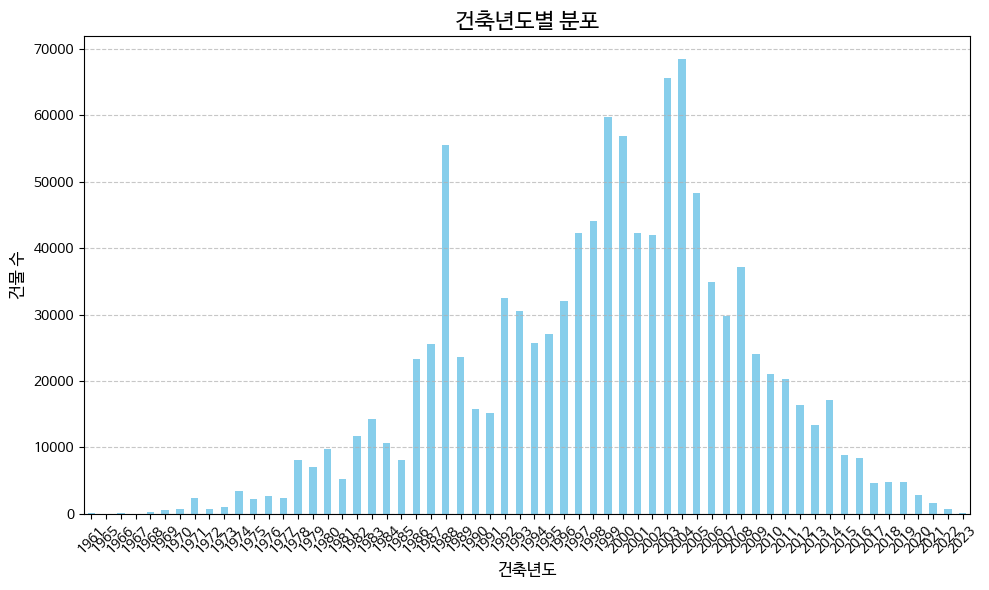

In [8]:
# Count occurrences of '건축년도' and sort values
year_counts = df['건축년도'].value_counts().sort_index()

# Plot the sorted value counts
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('건축년도별 분포', fontsize=16)
plt.xlabel('건축년도', fontsize=12)
plt.ylabel('건물 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
df['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.118822e+06
mean     1.998755e+03
std      9.333908e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

2000년 전후로 건축아파트 개수가 비슷함
상하위 10%는 각 1986년 2010년

아마도 base_code와 차이가나는것은 이상치를 제거한 데이터이기 때문

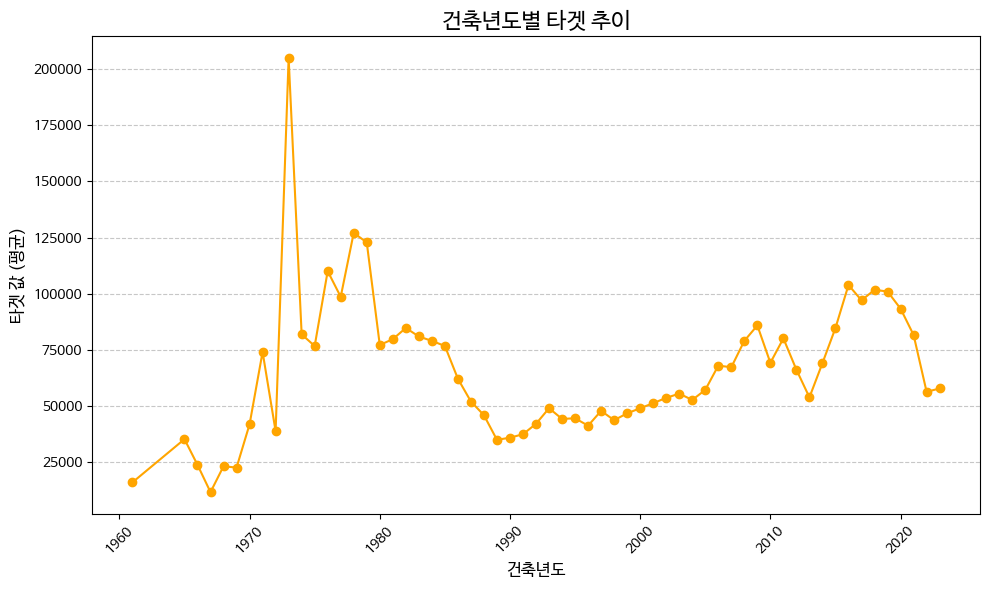

In [10]:
# Group by '건축년도' and calculate the mean/total of the target variable
target_trend = df.groupby('건축년도')['target'].mean().sort_index()  # 평균 계산

# Plot the target trend by construction year
plt.figure(figsize=(10, 6))
target_trend.plot(kind='line', marker='o', color='orange')  # Line plot으로 변경
plt.title('건축년도별 타겟 추이', fontsize=16)
plt.xlabel('건축년도', fontsize=12)
plt.ylabel('타겟 값 (평균)', fontsize=12)  # 합계일 경우: '타겟 값 (합계)'
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [11]:
module.preprocess.시_군_구_add(df)
module.preprocess.번지주소_add(df)

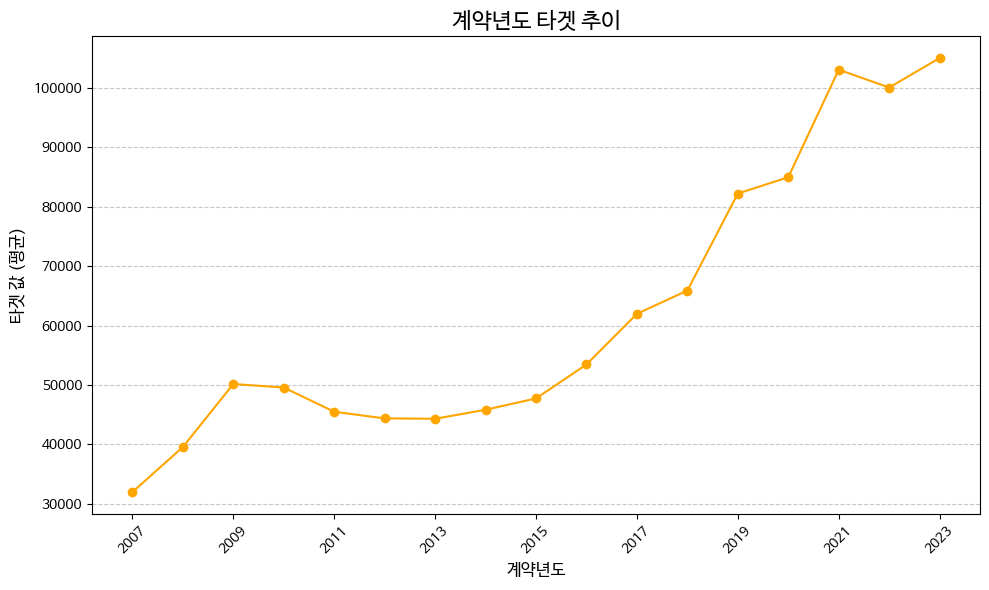

In [12]:
# Group by '건축년도' and calculate the mean/total of the target variable
target_trend = df.groupby('계약연도')['target'].mean().sort_index()  # 평균 계산

# Plot the target trend by construction year
plt.figure(figsize=(10, 6))
target_trend.plot(kind='line', marker='o', color='orange')  # Line plot으로 변경
plt.title('계약년도 타겟 추이', fontsize=16)
plt.xlabel('계약년도', fontsize=12)
plt.ylabel('타겟 값 (평균)', fontsize=12)  # 합계일 경우: '타겟 값 (합계)'
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

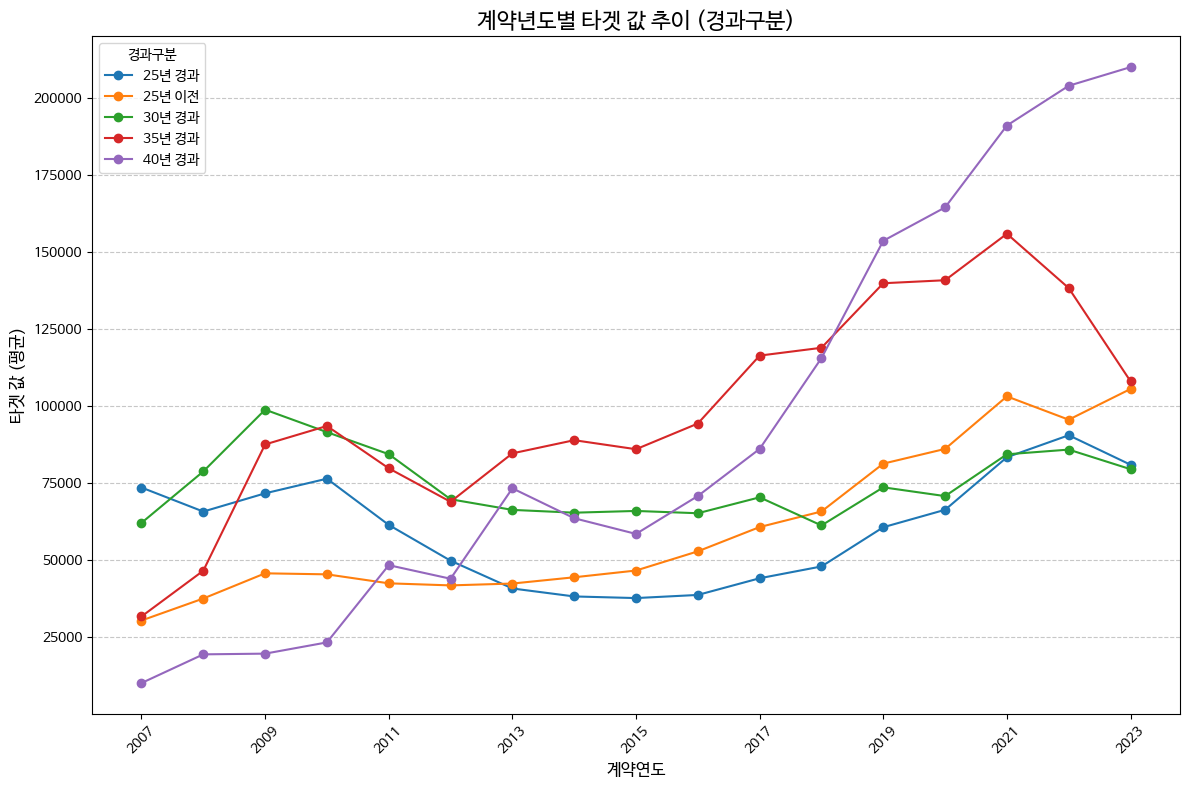

In [16]:

# Create a new column for the age of the building
df['경과연도'] = df['계약연도'].astype(int) - df['건축년도'].astype(int)

# Define the categories based on '경과연도'
def categorize(years):
    if years >= 40:
        return '40년 경과'
    elif years >= 35:
        return '35년 경과'
    elif years >= 30:
        return '30년 경과'
    elif years >= 25:
        return '25년 경과'
    else:
        return '25년 이전'

df['경과구분'] = df['경과연도'].apply(categorize)

# Group by '계약연도' and '경과구분', then calculate the mean target value
grouped = df.groupby(['계약연도', '경과구분'])['target'].mean().unstack()

# Plot the grouped data
plt.figure(figsize=(12, 8))
grouped.plot(kind='line', marker='o', figsize=(12, 8))

plt.title('계약년도별 타겟 값 추이 (경과구분)', fontsize=16)
plt.xlabel('계약연도', fontsize=12)
plt.ylabel('타겟 값 (평균)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='경과구분', fontsize=10)
plt.tight_layout()
plt.show()

경과구분        25년 경과         25년 이전        30년 경과         35년 경과         40년 경과
계약연도                                                                         
2007  73640.070828   30466.448386  62157.992233   31777.771208   10160.000000
2008  65834.971874   37604.906113  78866.688235   46633.841751   19476.562500
2009  71761.597001   45785.686598  98917.673671   87631.143979   19706.493671
2010  76507.691896   45451.860050  91623.233803   93620.158371   23357.150000
2011  61499.493910   42536.954552  84464.966334   79879.166259   48432.666667
2012  49887.279748   41864.371720  69829.067965   69009.503667   44022.101911
2013  40864.679430   42466.849167  66381.656990   84734.341533   73384.172691
2014  38277.030394   44500.335664  65471.343771   89008.634146   63671.393443
2015  37749.756779   46694.228318  66037.546601   86077.450407   58574.520952
2016  38765.067194   52922.149422  65291.389633   94418.157688   70883.071536
2017  44182.864908   60806.629026  70459.168991  116473.714323  

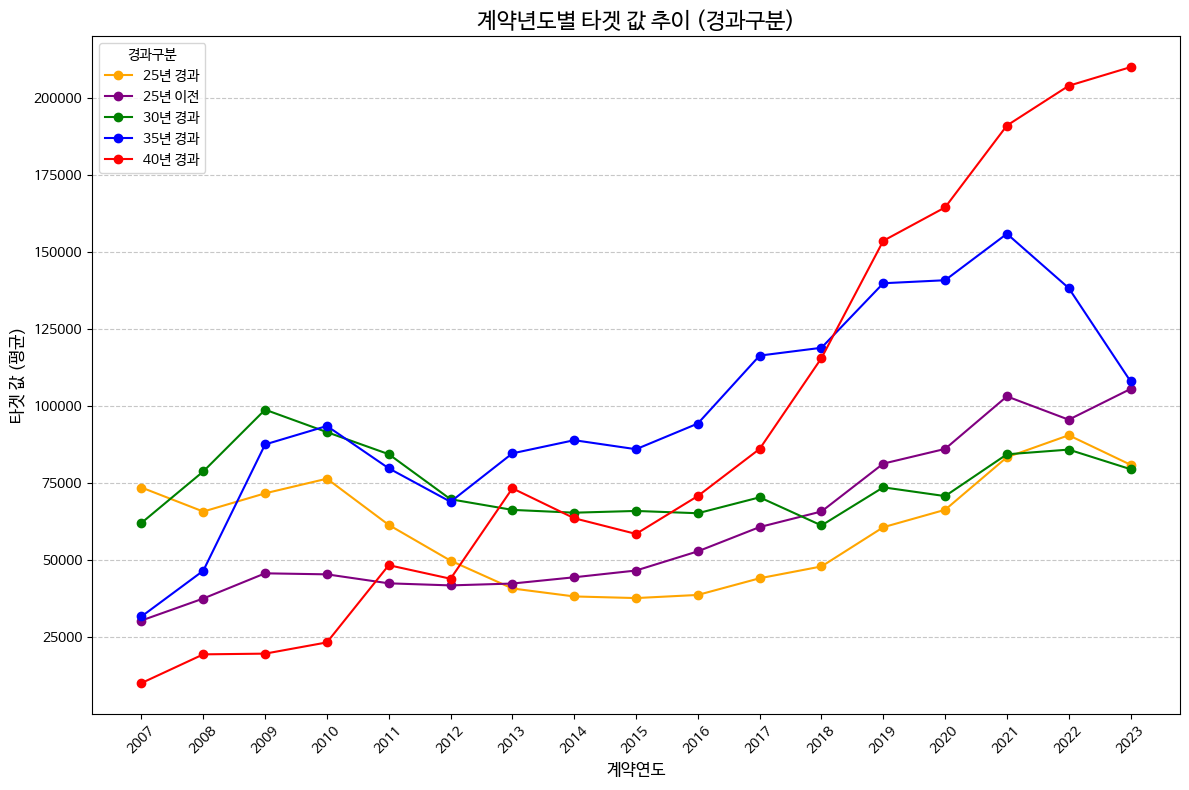

In [18]:
# Create a new column for the age of the building
df['경과연도'] = df['계약연도'].astype(int) - df['건축년도'].astype(int)

# Define the categories based on '경과연도'
def categorize(years):
    if years >= 40:
        return '40년 경과'
    elif years >= 35:
        return '35년 경과'
    elif years >= 30:
        return '30년 경과'
    elif years >= 25:
        return '25년 경과'
    else:
        return '25년 이전'

df['경과구분'] = df['경과연도'].apply(categorize)

# Group by '계약연도' and '경과구분', then calculate the mean target value
grouped = df.groupby(['계약연도', '경과구분'])['target'].mean().unstack()
print(grouped)

# Set specific colors for each category
category_colors = {
    '40년 경과': 'red',
    '35년 경과': 'blue',
    '30년 경과': 'green',
    '25년 경과': 'orange',
    '25년 이전': 'purple'
}

# Plot the grouped data with specific colors
plt.figure(figsize=(12, 8))
for category in grouped.columns:
    plt.plot(grouped.index, grouped[category], marker='o', label=category, color=category_colors[category])

plt.title('계약년도별 타겟 값 추이 (경과구분)', fontsize=16)
plt.xlabel('계약연도', fontsize=12)
plt.ylabel('타겟 값 (평균)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='경과구분', fontsize=10)
plt.tight_layout()
plt.show()


파생변수:
1. 경과 연도를 이진 변수로 단순화:
    - 40년 이상: 1, 그 외: 0
2. 경과 연도를 범주화하여 One-Hot Encoding 적용:
    - 예: 25년 이전, 25~30년, 30~35년, 35~40년, 40년 이상
3. 시간의 흐름에 따른 경과구분 비율:
    - 각 계약연도에서 40년 경과와 35년 경과의 비율을 계산하여 시간 흐름에 따른 변화를 추적.

강력한 파생변수는 40년 경과 또는 **35년 경과**

경과구분     25년 경과      25년 이전     30년 경과     35년 경과     40년 경과  40년 경과 비율  \
계약연도                                                                      
2007  122684358  1711513671   32011366   12361553     203200   0.000108   
2008  173211811  2000656215   67036685   13850251     623250   0.000276   
2009  449801690  2928132015  240073194   66950194    1556813   0.000422   
2010  200144122  1798257391  162631240   41380110    1401429   0.000636   
2011  212050255  2067508676  160567901   32670579    7264900   0.002929   
2012  166024867  1450474887  161305147   28224887    6911470   0.003812   
2013  295615091  2368673446  235522119   89564199   18272659   0.006075   
2014  396703143  3029449351  290627295  145974160   38839550   0.009955   
2015  554090930  4434877723  387574361  285518903   61503247   0.010746   
2016  470762976  4031979798  443393827  264654096   94132719   0.017744   
2017  557631938  4790285428  560784526  441551851  150206782   0.023107   
2018  395597991  40410402

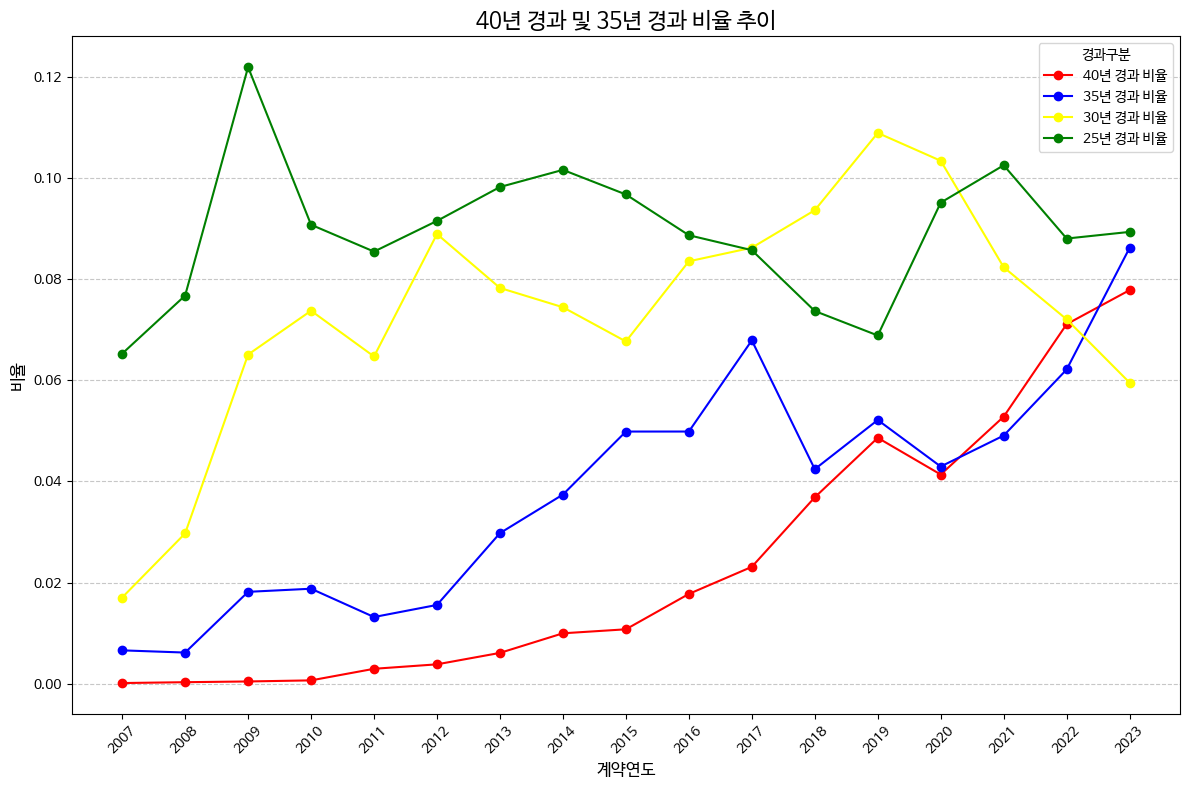

In [28]:
# 각 계약연도에서 전체 타겟 값 합계 계산
total_by_year = df.groupby('계약연도')['target'].sum()

# 각 계약연도에서 '40년 경과'와 '35년 경과'의 타겟 값 합계 계산
grouped_by_category = df.groupby(['계약연도', '경과구분'])['target'].sum().unstack()

# 비율 계산
grouped_by_category['40년 경과 비율'] = grouped_by_category['40년 경과'] / total_by_year
grouped_by_category['35년 경과 비율'] = grouped_by_category['35년 경과'] / total_by_year
grouped_by_category['30년 경과 비율'] = grouped_by_category['30년 경과'] / total_by_year
grouped_by_category['25년 경과 비율'] = grouped_by_category['25년 경과'] / total_by_year
# 30년 경과

print(grouped_by_category)
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(grouped_by_category.index, grouped_by_category['40년 경과 비율'], marker='o', label='40년 경과 비율', color='red')
plt.plot(grouped_by_category.index, grouped_by_category['35년 경과 비율'], marker='o', label='35년 경과 비율', color='blue')
plt.plot(grouped_by_category.index, grouped_by_category['30년 경과 비율'], marker='o', label='30년 경과 비율', color='yellow')
plt.plot(grouped_by_category.index, grouped_by_category['25년 경과 비율'], marker='o', label='25년 경과 비율', color='green')

plt.title('40년 경과 및 35년 경과 비율 추이', fontsize=16)
plt.xlabel('계약연도', fontsize=12)
plt.ylabel('비율', fontsize=12)
plt.legend(title='경과구분', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


데이터 분석 결과, 30년 경과, 35년 경과, 40년 경과와 같은 경과구분이 시간이 지남에 따라 비율의 변화가 뚜렷하게 나타나고 있습니다. 특히, 40년 경과는 최근 몇 년간 비율이 급격히 증가하며 시장에서 중요한 요소로 부각되고 있으며, 35년 경과는 안정적인 비율을 유지하면서 시장에서 지속적으로 중요한 위치를 차지하고 있습니다. 또한, 30년 경과는 중간 비율로서 데이터의 연속성을 보장하며, 세 가지 범주 모두 시장의 구조적 변화를 잘 설명할 수 있는 지표로 보입니다.

이러한 점을 고려할 때, **30년 경과, 35년 경과, 40년 경과를 원핫인코딩(One-Hot Encoding)**하여 파생변수로 활용하는 것이 합리적인 선택으로 보입니다. 

In [15]:
print(df['시'].isnull().sum())
print(df['구'].isnull().sum())
print(df['동'].isnull().sum())
print(df['건축년도'].isnull().sum())


0
0
0
0


In [13]:
# 중복 주소에 대해 아파트명이 다른 경우 필터링
filtered_df = (
    df.groupby('번지주소')
    .filter(lambda x: x['아파트명'].nunique() > 1)
)

In [26]:
filtered_df['keydata'] = filtered_df['번지주소'] + filtered_df['아파트명']+filtered_df['건축년도'].astype(str)

In [ ]:
filtered_df.head(1)

In [ ]:
# 같은 번지 건축년도가 다르면 재건축일수있음
unique_df = filtered_df.drop_duplicates(subset='keydata')
unique_df.shape


# 건축년도에 따른 아파트 가격 평균

In [ ]:

# 건축년도별 아파트가격 평균 계산
avg_prices_by_year = df.groupby("건축년도")["target"].mean()

# 그래프 그리기
plt.figure(figsize=(10, 6))
avg_prices_by_year.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("건축년도별 아파트가격 평균", fontsize=16)
plt.xlabel("건축년도", fontsize=12)
plt.ylabel("아파트가격 평균 (만원)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1973년은 평균이 왜 이렇게 높은가?

In [66]:
년도1973 = df[(df['건축년도'] == 1973)]


In [67]:
result = 년도1973.groupby('아파트명').agg(계약건수=('아파트명', 'count'), 평균가격=('target', 'mean')).reset_index()

In [ ]:
result.sort_values(by='계약건수', ascending=False)
# 반포주공1단지 계약건수가 압도적으로 많음

[[부동산 인사이트] 아파트의 미래 보여줄 반포주공1단지 재건축](https://www.bizhankook.com/bk/article/27491)
재건축으로 인한 계약건수가 늘어난것으로 보인다.

1. 계약년도별 건수 추이 확인
2. 계약년도별 가격 추이 확인

In [81]:
# 계약년도별 계약 건수 계산
banpo1 = df[df['아파트명'] == "반포주공1단지"].groupby('계약연도').size().reset_index(name='계약건수')



In [ ]:
# 계약년도별 평균 계약가격 시각화
plt.bar(banpo1['계약연도'], banpo1['계약건수'])
plt.title('반포주공1단지 계약년도별 계약건수')
plt.xlabel('계약년도')
plt.ylabel('계약건수')
plt.xticks(rotation=45)
plt.show()

In [ ]:
result
# 2009에 계약건수가 가장 많음
# 2009 - 1973 = 36년


<!-- 1992년 이후 준공된 아파트: 40년
1982년~1991년에 준공된 아파트: 22~39년
1981년 이전 준공된 아파트: 20년 -->

재건축지정이되고 확정되기까지 포함한다면 35년정도가 적합하지 않을까?

In [52]:
년도1973['keydata'] = 년도1973['번지주소'] + 년도1973['아파트명']

In [63]:
# 특정 열의 유니크 값
# unique_values = 년도1973['번지주소'].unique()
df_no_duplicates = 년도1973.drop_duplicates(subset='번지주소')


In [64]:
# array(['서울특별시 서대문구 홍제동 157-68', '서울특별시 서초구 반포동 757',
#     '서울특별시 용산구 보광동 260-6', '서울특별시 용산구 이촌동 302-28', '서울특별시 용산구 후암동 426',
#    '서울특별시 은평구 갈현동 467-2', '서울특별시 종로구 창신동 578-5', '서울특별시 종로구 필운동 142',
#   '서울특별시 용산구 이태원동 102-12', '서울특별시 용산구 한남동 1-35'], dtype=object)

In [ ]:
df_no_duplicates